In [1]:
# mesmerize stuff
from pathlib import Path
from caiman import load_memmap
from ipywidgets import IntSlider, interact, Button, HBox, VBox, Play, jslink, IntRangeSlider
import pandas as pd
from mesmerize_core import CaimanDataFrameExtensions, CaimanSeriesExtensions, \
    CNMFExtensions, MCorrExtensions, set_parent_data_path, get_parent_data_path
from mesmerize_core.utils import quick_min_max
from numpy import nanmin, nanmax
from scipy.io import loadmat
import numpy as np

In [ ]:
class TrialNotFound(Exception):
    pass


from scipy.io import loadmat
from skvideo.io import vread
from skvideo.utils import rgb2gray
@pd.api.extensions.register_series_accessor("behavior")
class Behavior:
    """
    Extensions for behavior data
    """
    def __init__(self, series: pd.Series):
        self._series = series
        self.session_id = self._series['name'].split('_')[0]
        self.cell_type = self._series['name'].split('_')[1][:2]
        self.animal_id = self._series['input_movie_path'].split('/')[0]

    def _get_behavior_path(self, trial_ix: int, view: str) -> Path:
        return get_parent_data_path().joinpath(self.animal_id, f'{self.session_id}_{self.cell_type}', 'Behavior', view)
    
    def _check_files(self, p, message: str):
        """
        message is either "movie" or "tracks file"
        """
        
        if len(p) > 1:
            raise ValueError(f"More than one {message} found with trial index: {trial_ix} at path: {behavior_path}")
            
        if len(p) == 0:
            raise TrialNotFound(f"No behavior {message} found with trial index: {trial_ix} at path: {behavior_path}")
    
    def get_behavior_tracks(self, trial_ix: int, view: str) -> Path:
        behavior_path = self._get_behavior_path(**kwargs)
        
        view = kwargs[view]
        
        if view == 'pellet':
            _view = 'front'
        
        p = list(behavior_path.glob(f"trk*{_view}_v{i:03}.mat"))
        
        self._check_files(p, "tracks file")
        
        if view == 'side':
            return loadmat(p)['pred_locs'][:, 0, :]
        
        if view == 'front':
            return loadmat(p)['pred_locs'][:, 0, :]
        
        if view == 'pellet':
            return loadmat(p)['pred_locs'][:, 1, :]
        
    def get_behavior_movie_path(self, trial_ix: int, view: str) -> Path:
        """
        kwargs passed to `_get_behavior_path()`
        """
        behavior_path = self._get_behavior_path(trial_ix, view)
        
        p = list(behavior_path.glob(f'*{view}_v{trial_ix:03}.avi'))
        
        self._check_files(p, "movie")
        
        return p[0]
    
    def get_behavior_movie(self, trial_ix: int, view: str) -> np.ndarray:
        """
        view: front or side
        
        returns grayscale in shape [n_frames, x, y]
        """
        return rgb2gray(vread(str(self.get_behavior_movie_path(trial_ix, view))))[:, :, :, ]

In [2]:
set_parent_data_path('/home/kushal/rotations/hantman')

# load the batch dataframe
sess_name = '121819_IT'
cnmf_df = pd.read_pickle('/home/kushal/rotations/hantman/hdf5s_march15/JoyJ2/batch/batch_cnmf.pickle')
cnmf_df = cnmf_df[cnmf_df['name'].str.startswith(sess_name)]
cnmf_df

,algo,name,input_movie_path,params,outputs,uuid
0,cnmf,121819_IT-m1,JoyJ2/121819_IT/7dd6588e-d4c1-4363-a8e0-35141f...,"{'refit': True, 'cnmf_kwargs': {'p': 2, 'nb': ...",{'cnmf-hdf5-path': JoyJ2/121819_IT/4d72d32a-1e...,4d72d32a-1e55-4898-858e-1c7fd4cad0dc
1,cnmf,121819_IT-ppc,JoyJ2/121819_IT/c1c266b4-405f-4c9d-a8c6-30697b...,"{'refit': True, 'cnmf_kwargs': {'p': 2, 'nb': ...",{'cnmf-hdf5-path': JoyJ2/121819_IT/4b92e5dc-4c...,4b92e5dc-4ca0-4074-9b76-47a635dfdc89
2,cnmf,121819_IT-rfa,JoyJ2/121819_IT/0bc5f56d-57a5-4a79-8f15-3710c9...,"{'refit': True, 'cnmf_kwargs': {'p': 2, 'nb': ...",{'cnmf-hdf5-path': JoyJ2/121819_IT/0a336f84-02...,0a336f84-021a-432a-9727-db652cdae577
3,cnmf,121819_IT-s1,JoyJ2/121819_IT/3ba0c3fd-7f3c-4231-bbe9-4cd7e7...,"{'refit': True, 'cnmf_kwargs': {'p': 2, 'nb': ...",{'cnmf-hdf5-path': JoyJ2/121819_IT/51a4abfd-40...,51a4abfd-4006-4a16-b837-d20cec275661


In [ ]:
vid = cnmf_df.iloc[0].behavior.get_behavior_movie(trial_ix=1, view="front")

In [ ]:
vid.shape

RFBOutputContext()


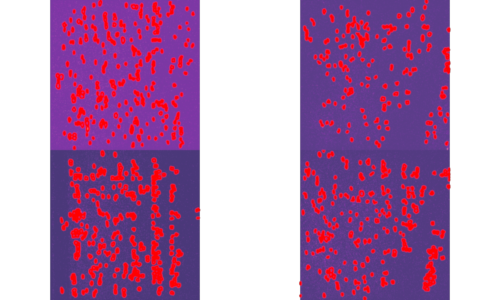

JupyterWgpuCanvas()

In [32]:
# pygfx stuff
from wgpu.gui.auto import WgpuCanvas, run
import pygfx as gfx
import numpy as np

canvas = WgpuCanvas()
renderer = gfx.renderers.WgpuRenderer(canvas)

dims = (512, 512)  # image dimensions
# default cam position
center_cam_pos = (256, 256, 0)

# colormaps for each of the 4 images
cmaps = \
    [
        gfx.cm.inferno,
        gfx.cm.plasma,
        gfx.cm.magma,
        gfx.cm.viridis
    ]

# lists of everything necessary to make this plot
scenes = list()
cameras = list()
memmaps = list()
images = list()
controllers = list()
cntl_defaults = list()
viewports = list()
roi_objects = dict()

for i, r in cnmf_df.iterrows():
    # create scene for this subplot
    scene = gfx.Scene()
    scenes.append(scene)
    
    memmap = r.cnmf.get_input_memmap()
    memmaps.append(memmap)
    
    vmin, vmax = quick_min_max(memmap)
    
    img = gfx.Image(
        gfx.Geometry(grid=gfx.Texture(memmap[0].astype(np.float32).T, dim=2)),
        gfx.ImageBasicMaterial(clim=(vmin, vmax), map=gfx.cm.inferno)
    )
    
    cnmf_obj = r.cnmf.get_output()
    idx_components = cnmf_obj.estimates.idx_components
    roi_coors = r.cnmf.get_spatial_contour_coors(idx_components)
    
    roi_objects[r['name']] = list()
    for rcs in roi_coors:
        colors = [np.array([1, 0, 0, 0.5])] * rcs.shape[0]
        
        rcs_z = np.zeros((rcs.shape[0], 3), dtype=np.float32)
        rcs[:, 0] += img.position.x
        rcs[:, 1] += img.position.y
        rcs_z[:, :-1] = rcs.astype(np.float32)
        rcs_z
        
        geometry = gfx.Geometry(indices=np.arange(rcs_z.shape[0]), positions=rcs_z, colors=colors)
        # material = gfx.MeshBasicMaterial(vertex_colors=True)#wireframe=True, wireframe_thickness=0.5, color=(1, 0, 0, 0.5), vertex_colors=True)
        material = gfx.LineMaterial(thickness=2, color="red")#, vertex_colors=True)
        line = gfx.Line(geometry, material)
        line.position.z = 1
        roi_objects[r['name']].append(line)
        scene.add(line)

    # add image to list
    images.append(img)
    scene.add(img)

    # create camera, set default position, add to list
    camera = gfx.OrthographicCamera(*dims)
    camera.position.set(*center_cam_pos)
    cameras.append(camera)

    # create viewport for this image
    viewport = gfx.Viewport(renderer)
    viewports.append(viewport)

    # controller for pan & zoom
    controller = gfx.PanZoomController(camera.position.clone())
    controller.add_default_event_handlers(viewport, camera)
    controllers.append(controller)

    # get the initial controller params so the camera can be reset later
    cntl_default = dict()
    cntl_default['distance'] = controller.distance
    cntl_default['zoom_value'] = controller.zoom_value
    cntl_default['target'] = controller.target.clone()
    cntl_defaults.append(cntl_default)

w_div = 2
h_div = 2


# 2x2 arrangement for the viewports
def produce_rect(w, h):
    return [
        (0, 0, w / w_div, h / h_div),
        (w / w_div, 0, w / w_div, h / h_div),
        (0, h / h_div, w / w_div, h / h_div),
        (w / w_div, h / h_div, w / w_div, h / h_div)
    ]


# ipywidgets stuff

reset_cameras = False
reset_button = Button(description="Reset View")

def on_button_clicked(b):
    global reset_cameras
    reset_cameras = True

reset_button.on_click(on_button_clicked)

last_ix = memmaps[0].shape[0] - 1

play = Play(
    value=0,
    min=0,
    max=last_ix,
    step=1,
    interval=100,
)

frame_slider = IntSlider()
frame_slider.max = last_ix

jslink((play, 'value'), (frame_slider, 'value'))

vminmax_sliders = list()

for memmap in memmaps:
    vmin, vmax = tuple(map(int, quick_min_max(memmap)))
    
    vminmax_sliders.append(IntRangeSlider(
        value=(vmin, vmax),
        min=0,
        max=1000 + vmax,
        step=5,
        description='levels',
        orientation='vertical',
        readout=True,
        readout_format='d',
    ))
    

def animate():
    for i, (img, memmap) in enumerate(zip(images, memmaps)):
        # create new image data
        img.geometry.grid.data[:] = memmap[frame_slider.value].astype(np.float32).T
        img.geometry.grid.update_range((0, 0, 0), img.geometry.grid.size)
        
        # update vmin, vmax
        vmin, vmax = vminmax_sliders[i].value
        
        if (img.material.clim[0] != vmin) or (img.material.clim[1] != vmax):
            img.material.clim = (vmin, vmax)

    w, h = canvas.get_logical_size()

    rects = produce_rect(w, h)

    global reset_cameras

    # reset the cameras if `reset_camera` is set to True
    if reset_cameras:
        for camera, controller, cntrl_default in zip(cameras, controllers, cntl_defaults):
            pan_delta = cntl_default['target'].clone().sub(camera.position)  # find the dx, dy
            controller.pan(pan_delta)  # pan to initial state

            # set zoom and distance to initial state
            controller.zoom_value = cntl_default['zoom_value']
            controller.distance = cntl_default['distance']

            # update camera with the new params
            controller.update_camera(camera)

        reset_cameras = False
    else:
        for camera, controller, cntrl_default in zip(cameras, controllers, cntl_defaults):
            # if not reset, update with the pan & zoom params
            controller.update_camera(camera)

    # render the viewports
    for viewport, s, c, r in zip(viewports, scenes, cameras, rects):
        viewport.rect = r
        viewport.render(s, c)

    renderer.flush()
    canvas.request_draw()
    
canvas.request_draw(animate)
canvas

In [33]:
VBox([
    HBox([reset_button, play, frame_slider]),
    HBox(vminmax_sliders)
])

In [34]:
previous_roi = None

def print_click_coors(roi_graphic_object):
    print(roi_graphic_object.geometry.positions.data.mean(axis=0)[:2])
    # return

    roi_graphic_object.material.color = "white"#(1, 1, 1, 1)
    roi_graphic_object.material.thickness = 2
    
    global previous_roi
    
    if previous_roi is roi_graphic_object:
        return
    
    if previous_roi is not None:
        previous_roi.material.color = "red"#(1, 0, 0, 0.5)
        previous_roi.material.thickness = 1.2
    
    previous_roi = roi_graphic_object
    
for roi in roi_objects['121819_IT-m1']:
    roi.add_event_handler(lambda event: print_click_coors(event.current_target), "pointer_move")


In [22]:
previous_roi

In [ ]:
for img in images:
    img.add_event_handler(lambda event: print(event.x, event.y), "pointer_move")

In [ ]:
roi._event_handlers

defaultdict(set,
            {'double_click': {<function __main__.<lambda>(event)>,
              <function __main__.<lambda>(event)>}})

In [ ]:

def get_center(roi_graphic_object):
    return roi_graphic_object.geometry.positions.data.mean(axis=0)

In [ ]:
cameras[0].position

Vector3(256.0, 256.0, -100.0)

In [ ]:
viewports[0].rect

(0.0, 0.0, 556.0, 556.5)

In [ ]:
roi.geometry.positions.data.mean(axis=0)[:2]

array([190.62468,  85.68838], dtype=float32)